In [5]:
from Learners_Generator import *
import Functions as f
from Enviroment import *
from Clairvoyant import *
from Classes import *
from GPUCB1_TS import *
from GPTS_TS import *
import Plots as p
import warnings
warnings.filterwarnings("ignore")  # Convergence warning concerning the parameters of the GP since we are working with very large values


In [6]:
pricing_arms=[10,15,20,25,30]

advertising_arms=np.linspace(100,397,100)


In [7]:
cl=Classes()





env=Enviroment(5,100,cl)

In [8]:
runs=2
T=365
show_print=False

cum_regret_gpucb_multi=[]
cum_reward_gpucb_multi=[]
istant_regret_gpucb_multi=[]
istant_reward_gpucb_multi=[]

cum_regret_gpts_multi=[]
cum_reward_gpts_multi=[]
istant_regret_gpts_multi=[]
istant_reward_gpts_multi=[]

cum_regret_gpucb_multi_gen=[]
cum_reward_gpucb_multi_gen=[]
istant_regret_gpucb_multi_gen=[]
istant_reward_gpucb_multi_gen=[]

cum_regret_gpts_multi_gen=[]
cum_reward_gpts_multi_gen=[]
istant_regret_gpts_multi_gen=[]
istant_reward_gpts_multi_gen=[]


for r in range(runs):

    gpucb_sum=GPUCB1_TS(advertising_arms)
    gpts_sum=GPTS_TS(advertising_arms)
    gpucb_gen = Learners_Generator(GPUCB1_TS, advertising_arms)
    gpts_gen = Learners_Generator(GPTS_TS, advertising_arms)
    
    clairv_price_1=Clairvoyant_pricing(env , (1,1) ,pricing_arms )
    clairv_bid_1=Clairvoyant_bid(env,(1,1), advertising_arms)
    clairv_price_2=Clairvoyant_pricing(env , (0,1) ,pricing_arms )
    clairv_bid_2=Clairvoyant_bid(env,(0,1), advertising_arms)
    clairv_price_3=Clairvoyant_pricing(env , (0,0) ,pricing_arms )
    clairv_bid_3=Clairvoyant_bid(env,(0,0), advertising_arms)

    opt_price_1=clairv_price_1.optimal_arm()
    opt_price_2=clairv_price_2.optimal_arm()
    opt_price_3=clairv_price_3.optimal_arm()

    opt_bid_1=clairv_bid_1.optimal_arm(opt_price_1)
    opt_bid_2=clairv_bid_2.optimal_arm(opt_price_2)
    opt_bid_3=clairv_bid_3.optimal_arm(opt_price_3)

    expected_optimal_rew1=clairv_bid_1.expected_reward(opt_bid_1,opt_price_1)
    expected_optimal_rew2=clairv_bid_2.expected_reward(opt_bid_2,opt_price_2)
    expected_optimal_rew3=clairv_bid_3.expected_reward(opt_bid_3,opt_price_3)
    expected_optimal_rew_sum = expected_optimal_rew1 + expected_optimal_rew2 + expected_optimal_rew3

    if show_print:
        print(opt_price_1, opt_price_2 ,opt_price_3)
        print(opt_bid_1 , opt_bid_2 , opt_bid_3)
        print(expected_optimal_rew1,expected_optimal_rew2,expected_optimal_rew3)



    cum_reward_GPUCB=[0]
    cum_reward_GPTS=[0]
    cum_reward_gen_GPUCB=[0]
    cum_reward_gen_GPTS=[0]

    cumulative_optimal_rew_sum=[0]

    cum_regret_GPUCB=[]
    cum_regret_GPTS=[]
    cum_regret_gen_GPUCB=[]
    cum_regret_gen_GPTS=[]

    regret_GPUCB=np.zeros(T)+expected_optimal_rew_sum
    regret_GPTS=np.zeros(T)+expected_optimal_rew_sum
    regret_gen_GPUCB=np.zeros(T)+expected_optimal_rew_sum
    regret_gen_GPTS=np.zeros(T)+expected_optimal_rew_sum

    reward_GPUCB=[]
    reward_GPTS=[]
    reward_gen_GPUCB=[]
    reward_gen_GPTS=[]



    for t in range(T):

        cumulative_optimal_rew_sum.append(cumulative_optimal_rew_sum[t]+expected_optimal_rew_sum)

        pulled_arm_price_GPUCB, pulled_arm_bid_GPUCB=gpucb_sum.pull_arm()
        rewards_GPUCB=env.round([pulled_arm_price_GPUCB, pulled_arm_price_GPUCB, pulled_arm_price_GPUCB], [pulled_arm_bid_GPUCB, pulled_arm_bid_GPUCB, pulled_arm_bid_GPUCB])
        conversion_total = rewards_GPUCB[(1,1)][0] + rewards_GPUCB[(0,1)][0] + rewards_GPUCB[(0,0)][0]
        n_clicks = rewards_GPUCB[(1,1)][1] + rewards_GPUCB[(0,1)][1] + rewards_GPUCB[(0,0)][1]
        cum_cost = rewards_GPUCB[(1,1)][2] + rewards_GPUCB[(0,1)][2] + rewards_GPUCB[(0,0)][2]
        reward_tot = rewards_GPUCB[(1,1)][3] + rewards_GPUCB[(0,1)][3] + rewards_GPUCB[(0,0)][3]
        gpucb_sum.update(pulled_arm_price_GPUCB, pulled_arm_bid_GPUCB , [conversion_total, n_clicks, cum_cost, reward_tot])
    
        cum_reward_GPUCB.append(cum_reward_GPUCB[t]+reward_tot)
        cum_regret_GPUCB.append(cumulative_optimal_rew_sum[t+1]-cum_reward_GPUCB[t+1])
        regret_GPUCB[t]=regret_GPUCB[t]-reward_tot
        reward_GPUCB.append(reward_tot)


        pulled_arm_price_GPTS, pulled_arm_bid_GPTS = gpts_sum.pull_arm()
        rewards_GPTS=env.round([pulled_arm_price_GPTS, pulled_arm_price_GPTS, pulled_arm_price_GPTS], [pulled_arm_bid_GPTS, pulled_arm_bid_GPTS, pulled_arm_bid_GPTS])
        conversion_total = rewards_GPTS[(1,1)][0] + rewards_GPTS[(0,1)][0] + rewards_GPTS[(0,0)][0]
        n_clicks = rewards_GPTS[(1,1)][1] + rewards_GPTS[(0,1)][1] + rewards_GPTS[(0,0)][1]
        cum_cost = rewards_GPTS[(1,1)][2] + rewards_GPTS[(0,1)][2] + rewards_GPTS[(0,0)][2]
        reward_tot = rewards_GPTS[(1,1)][3] + rewards_GPTS[(0,1)][3] + rewards_GPTS[(0,0)][3]
        gpts_sum.update(pulled_arm_price_GPTS, pulled_arm_bid_GPTS , [conversion_total, n_clicks, cum_cost, reward_tot])

        cum_reward_GPTS.append(cum_reward_GPTS[t]+reward_tot)
        cum_regret_GPTS.append(cumulative_optimal_rew_sum[t+1]-cum_reward_GPTS[t+1])
        regret_GPTS[t]=regret_GPTS[t]-reward_tot
        reward_GPTS.append(reward_tot)
        
        #print('UCB')
        pulled_arm_gen_GPUCB = gpucb_gen.pull_arms()
        price_arms_gen_GPUCB = [pulled_arm_gen_GPUCB[0][0], pulled_arm_gen_GPUCB[1][0], pulled_arm_gen_GPUCB[2][0]]
        bid_arms_gen_GPUCB = [pulled_arm_gen_GPUCB[0][1], pulled_arm_gen_GPUCB[1][1], pulled_arm_gen_GPUCB[2][1]]
        rewards_gen_GPUCB = env.round(price_arms_gen_GPUCB, bid_arms_gen_GPUCB)
        istant_rew_GPUCB = gpucb_gen.update(price_arms_gen_GPUCB, bid_arms_gen_GPUCB, rewards_gen_GPUCB)
        
        cum_reward_gen_GPUCB.append(cum_reward_gen_GPUCB[t]+istant_rew_GPUCB)
        cum_regret_gen_GPUCB.append(cumulative_optimal_rew_sum[t+1]-cum_reward_gen_GPUCB[t+1])
        regret_gen_GPUCB[t]=regret_gen_GPUCB[t]-istant_rew_GPUCB
        reward_gen_GPUCB.append(istant_rew_GPUCB)
        
        #print('TS')
        pulled_arm_gen_GPTS = gpts_gen.pull_arms()
        price_arms_gen_GPTS = [pulled_arm_gen_GPTS[0][0], pulled_arm_gen_GPTS[1][0], pulled_arm_gen_GPTS[2][0]]
        bid_arms_gen_GPTS = [pulled_arm_gen_GPTS[0][1], pulled_arm_gen_GPTS[1][1], pulled_arm_gen_GPTS[2][1]]
        rewards_gen_GPTS = env.round(price_arms_gen_GPTS, bid_arms_gen_GPTS)
        istant_rew_GPTS = gpts_gen.update(price_arms_gen_GPTS, bid_arms_gen_GPTS, rewards_gen_GPTS)

        cum_reward_gen_GPTS.append(cum_reward_gen_GPTS[t]+istant_rew_GPTS)
        cum_regret_gen_GPTS.append(cumulative_optimal_rew_sum[t+1]-cum_reward_gen_GPTS[t+1])
        regret_gen_GPTS[t]=regret_gen_GPTS[t]-istant_rew_GPTS
        reward_gen_GPTS.append(istant_rew_GPTS)
        if t in [50,150,300,365]: print(t)

        
    cum_regret_gpucb_multi.append(cum_regret_GPUCB)
    cum_reward_gpucb_multi.append(cum_reward_GPUCB)
    istant_regret_gpucb_multi.append(regret_GPUCB)
    istant_reward_gpucb_multi.append(reward_GPUCB)

    cum_regret_gpts_multi.append(cum_regret_GPTS)
    cum_reward_gpts_multi.append(cum_reward_GPTS)
    istant_regret_gpts_multi.append(regret_GPTS)
    istant_reward_gpts_multi.append(reward_GPTS)

    cum_regret_gpucb_multi_gen.append(cum_regret_gen_GPUCB)
    cum_reward_gpucb_multi_gen.append(cum_reward_gen_GPUCB)
    istant_regret_gpucb_multi_gen.append(regret_gen_GPUCB)
    istant_reward_gpucb_multi_gen.append(reward_gen_GPUCB)

    cum_regret_gpts_multi_gen.append(cum_regret_gen_GPTS)
    cum_reward_gpts_multi_gen.append(cum_reward_gen_GPTS)
    istant_regret_gpts_multi_gen.append(regret_gen_GPTS)
    istant_reward_gpts_multi_gen.append(reward_gen_GPTS)


50
150
300
50
150
300


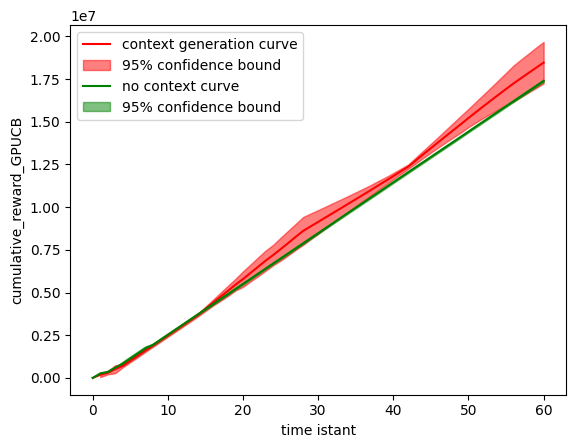

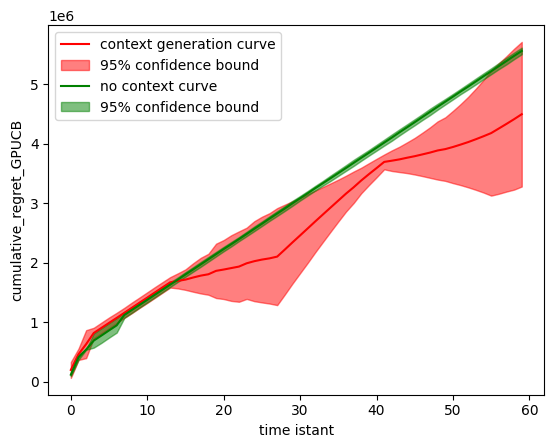

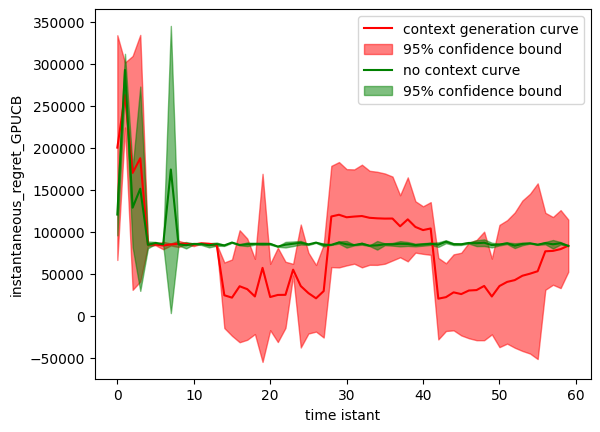

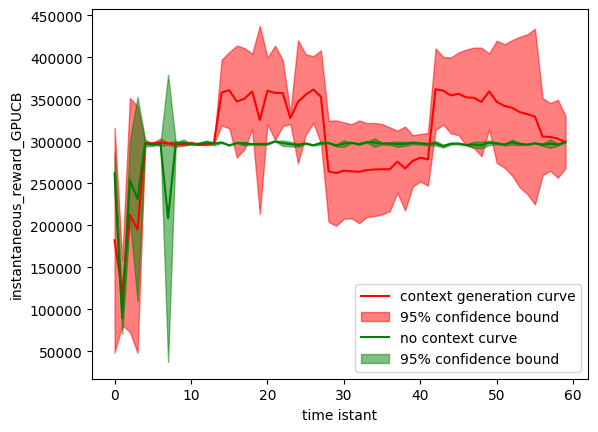

In [5]:
x=[i for i in range(T+1)]
arr1=np.array(cum_reward_gpucb_multi_gen)
arr2=np.array(cum_reward_gpucb_multi)
p.plot_comparison(x, arr1, arr2, "context generation curve", "no context curve", "cumulative_reward_GPUCB")

x=[i for i in range(T)]
arr1=np.array(cum_regret_gpucb_multi_gen)
arr2=np.array(cum_regret_gpucb_multi)
p.plot_comparison(x, arr1, arr2, "context generation curve", "no context curve", "cumulative_regret_GPUCB")

x=[i for i in range(T)]
arr1=np.array(istant_regret_gpucb_multi_gen)
arr2=np.array(istant_regret_gpucb_multi)
p.plot_comparison(x, arr1, arr2, "context generation curve", "no context curve", "instantaneous_regret_GPUCB")

x=[i for i in range(T)]
arr1=np.array(istant_reward_gpucb_multi_gen)
arr2=np.array(istant_reward_gpucb_multi)
p.plot_comparison(x, arr1, arr2, "context generation curve", "no context curve", "instantaneous_reward_GPUCB")

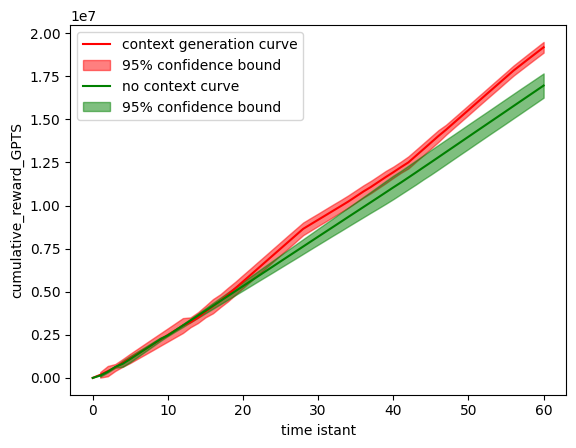

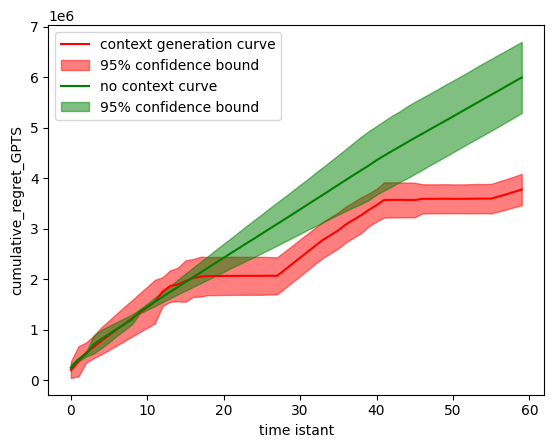

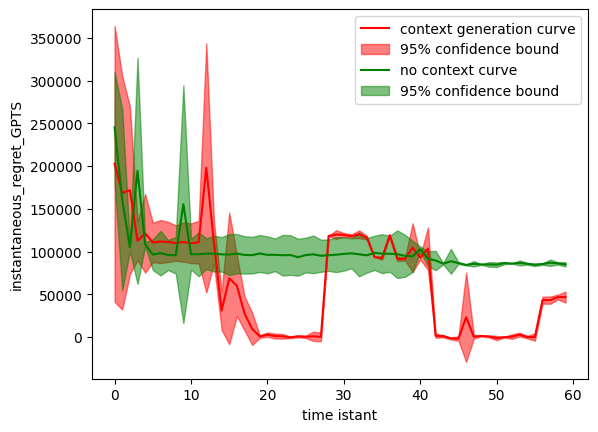

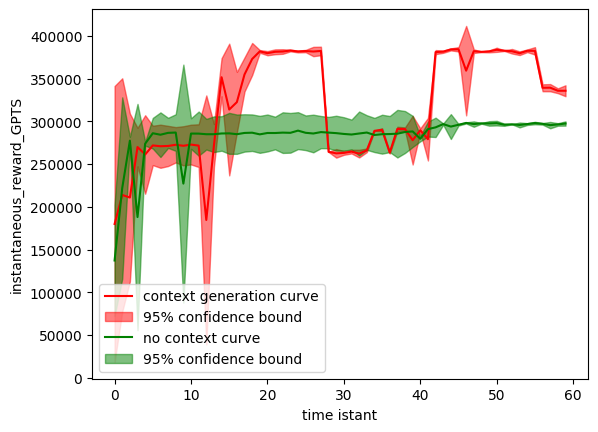

In [6]:
x=[i for i in range(T+1)]
arr1=np.array(cum_reward_gpts_multi_gen)
arr2=np.array(cum_reward_gpts_multi)
p.plot_comparison(x, arr1, arr2, "context generation curve", "no context curve", "cumulative_reward_GPTS")

x=[i for i in range(T)]
arr1=np.array(cum_regret_gpts_multi_gen)
arr2=np.array(cum_regret_gpts_multi)
p.plot_comparison(x, arr1, arr2, "context generation curve", "no context curve", "cumulative_regret_GPTS")

x=[i for i in range(T)]
arr1=np.array(istant_regret_gpts_multi_gen)
arr2=np.array(istant_regret_gpts_multi)
p.plot_comparison(x, arr1, arr2, "context generation curve", "no context curve", "instantaneous_regret_GPTS")

x=[i for i in range(T)]
arr1=np.array(istant_reward_gpts_multi_gen)
arr2=np.array(istant_reward_gpts_multi)
p.plot_comparison(x, arr1, arr2, "context generation curve", "no context curve", "instantaneous_reward_GPTS")